In [3]:
import pandas as pd
import numpy as np

In [5]:
# import breast cancer dataset from SKlearn
from sklearn.datasets import load_breast_cancer

# read dataframe first using feature data
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)

# add a target column and fill it with target data
df['target'] = data.target

#see into first five rows
print(df.shape)
df.head()

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [8]:
# let's build XgBoost model and setup modeling
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

y = df['target'].to_frame() # define Y
X = df[df.columns.difference(['target'])]  # define X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, ) # create train test

# build XGboost
xgb_mod = xgb.XGBClassifier(random_state=42, gpu_id=0) # build classifier
xgb_mod = xgb_mod.fit(X_train, y_train.values.ravel()) # !numy.ravel() = numpy.reshape(-1)

# make prediction and check model accuracy
y_pred = xgb_mod.predict(X_test)

# performance
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

[10:38:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 97.37%


C:\Users\ashoaib\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


## SHAP
One of the most popular methods today, **SHAP** (SHapley Additive exPlanations) is a game theory based approach to explain the output of any ML model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. **SHAP helps you understand the magnitude of impact (length of the bar) and direction(colour)**
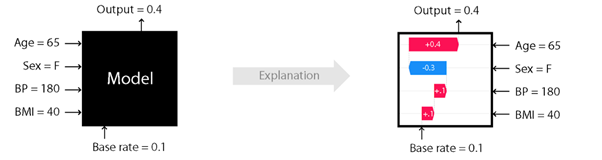

SHAP model agnostic framework has following graphs:
* Summary Dot plot
* Summary Bar plot
* Waterfall plot
* PDP plot
* force plots
* Decision pot

In [31]:
# generate tree explainer and SHAP values
import shap
explainer = shap.TreeExplainer(xgb_mod)
shap_values = explainer.shap_values(X)
expected_values = explainer.expected_value

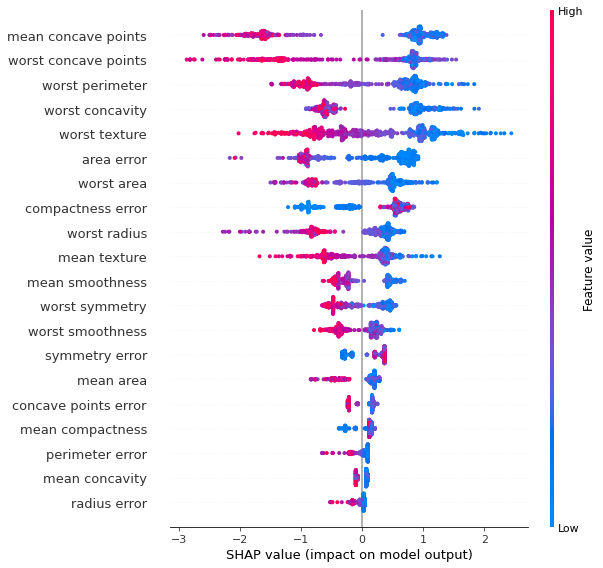

In [11]:
# Generate Summary dot plot
shap.summary_plot(shap_values, X, title='SHAP summary plot')

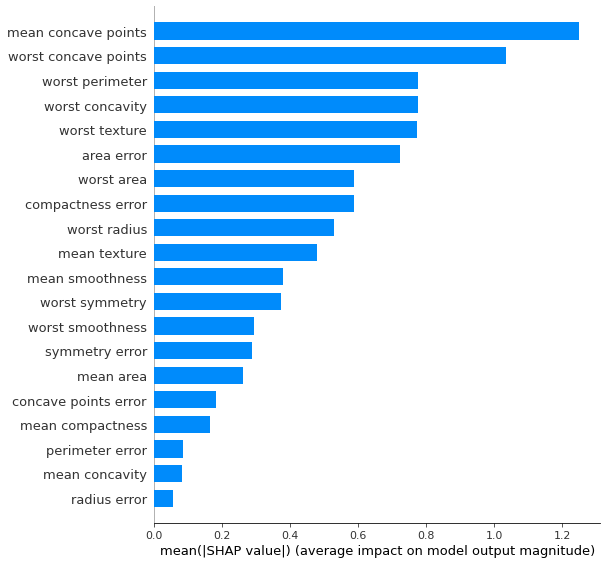

In [17]:
# generate summary bar plot
shap.summary_plot(shap_values, X, plot_type='bar')

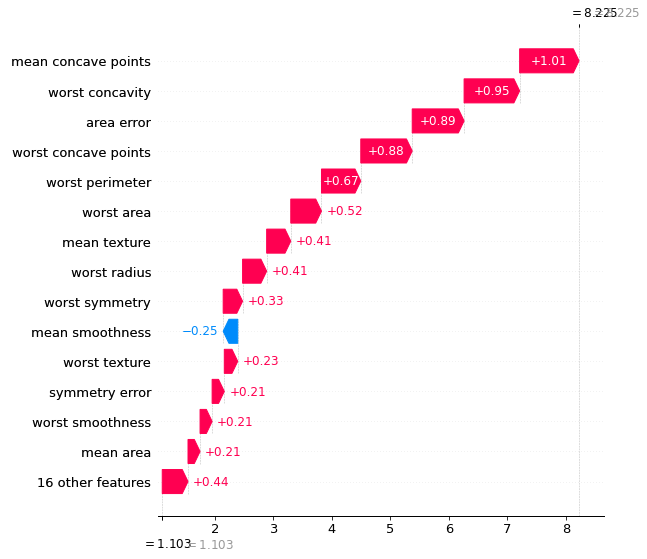

In [41]:
# generate waterfall plot
shap.plots._waterfall.waterfall_legacy(expected_values, shap_values[79], features=X.loc[79,:], feature_names=X.columns, max_display=15, show=True)

In [47]:
# Generate force plot - Single
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [48]:
# Generate force plot - Multiple rows 
shap.force_plot(explainer.expected_value, shap_values[:100,:], X.iloc[:100,:])

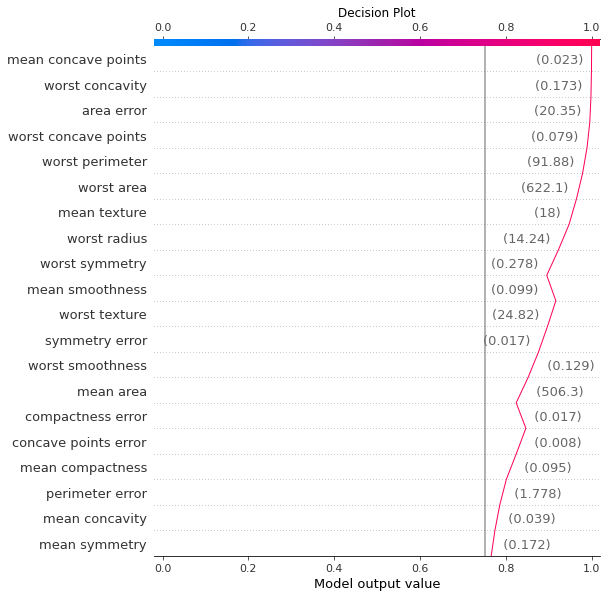

In [50]:
# Generate Decision plot 
shap.decision_plot(expected_values, shap_values[79],link='logit' ,features=X.loc[79,:], feature_names=(X.columns.tolist()),show=True,title="Decision Plot")

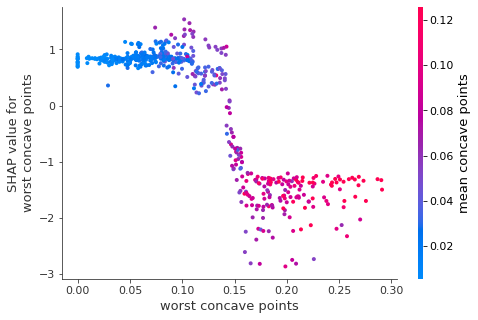

In [42]:
# Generate dependence plot
shap.dependence_plot("worst concave points", shap_values, X, interaction_index="mean concave points")

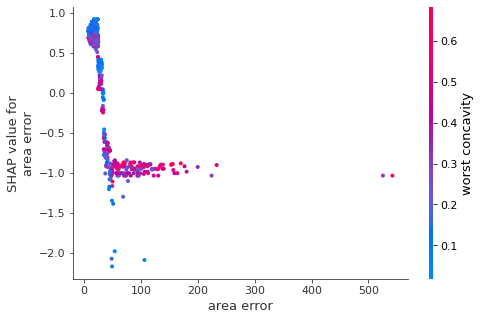

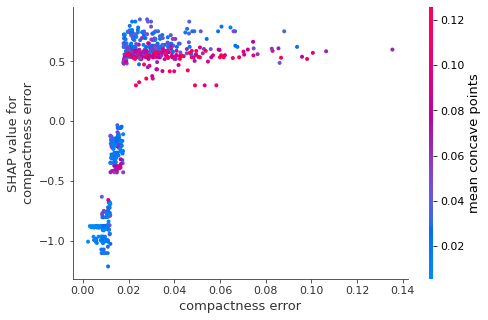

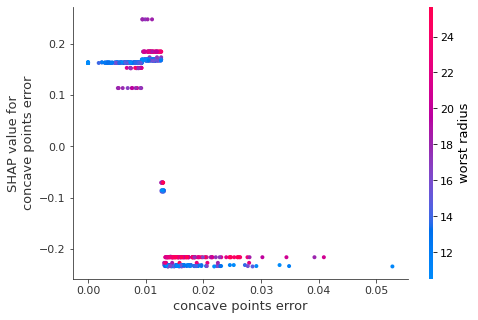

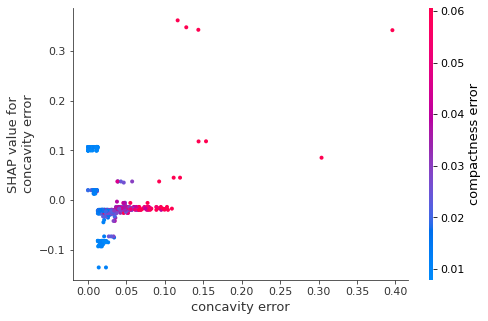

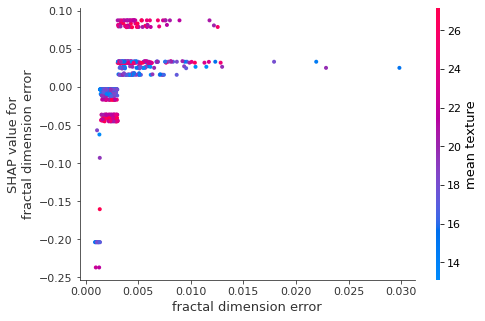

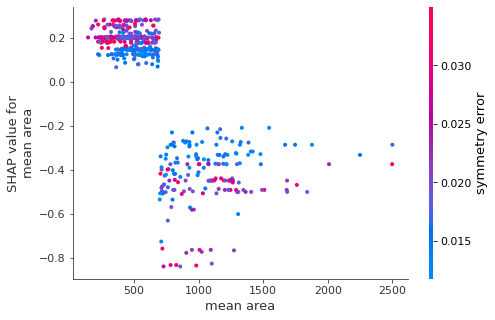

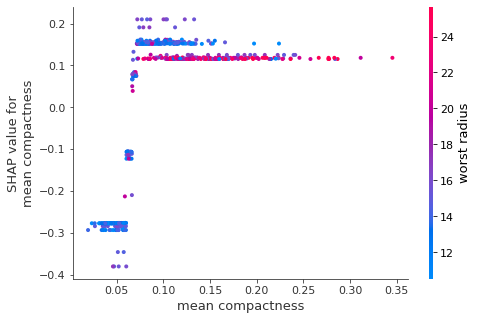

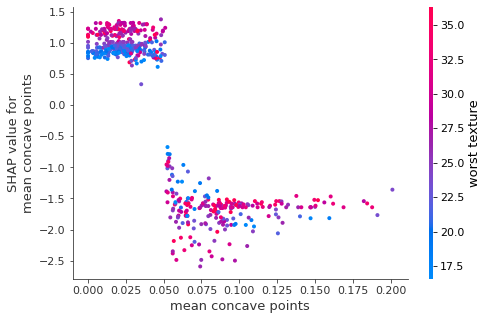

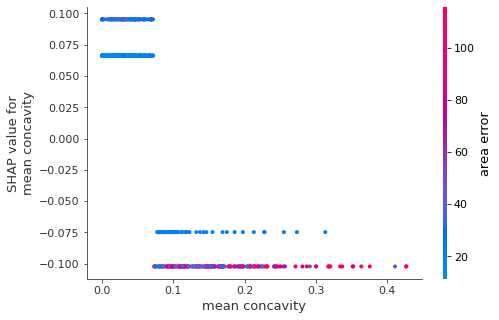

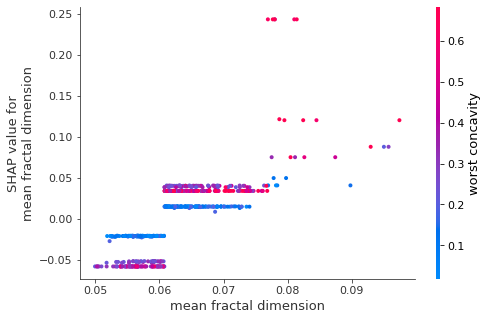

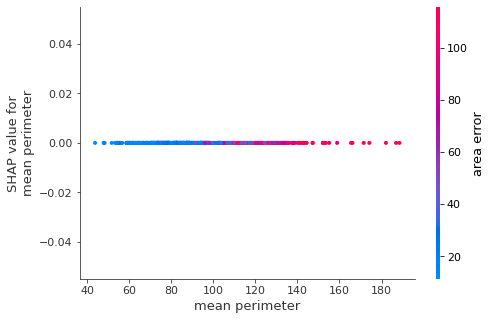

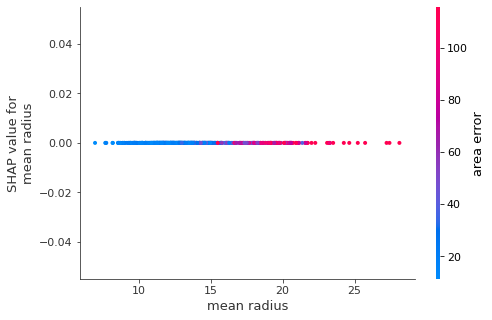

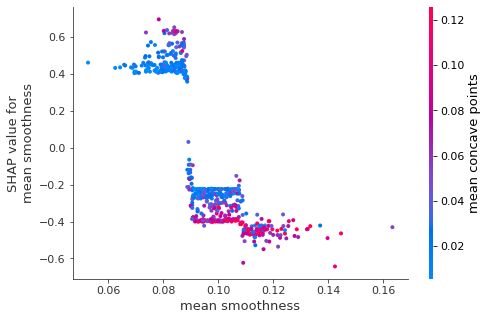

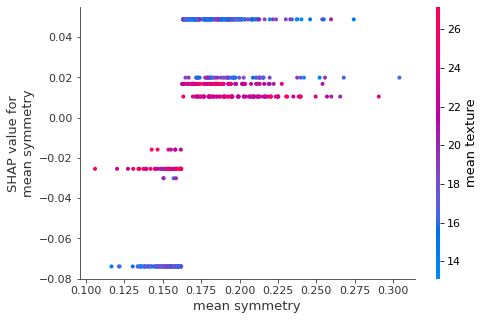

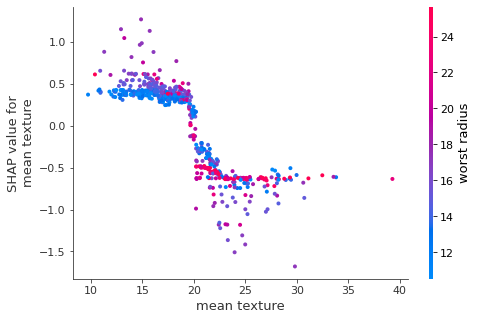

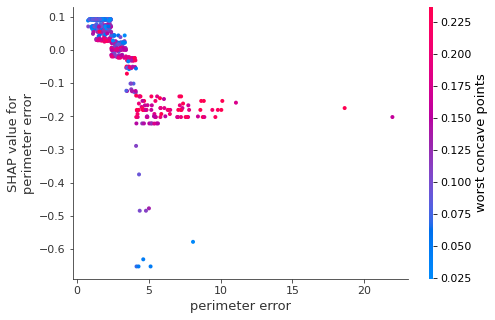

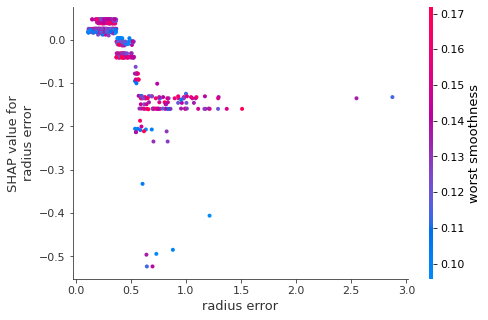

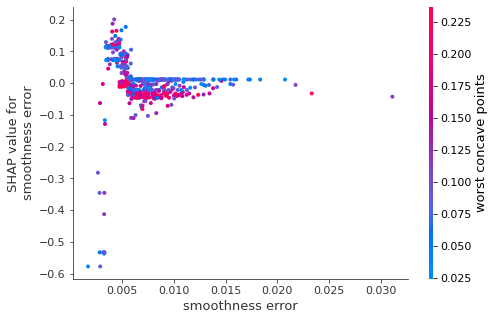

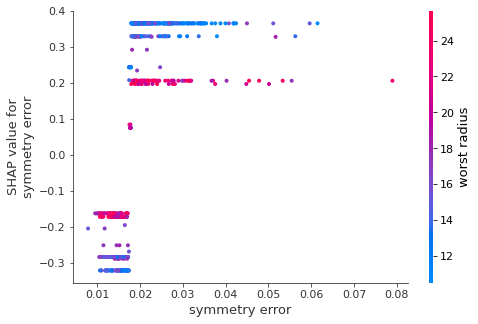

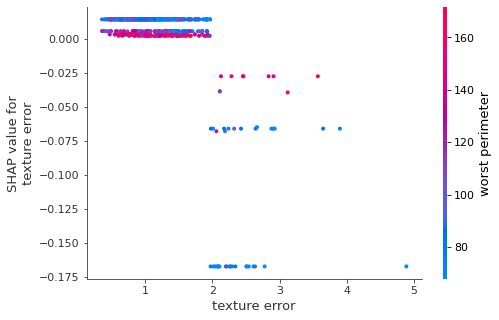

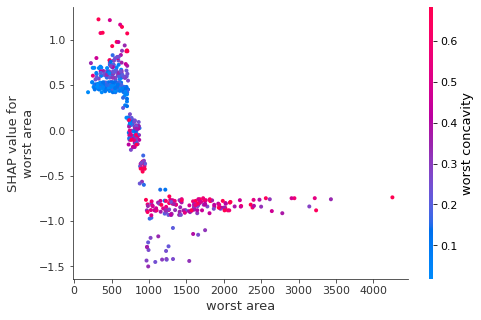

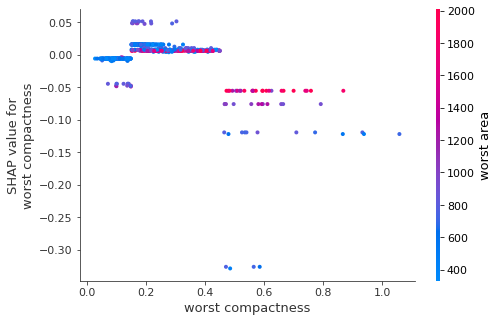

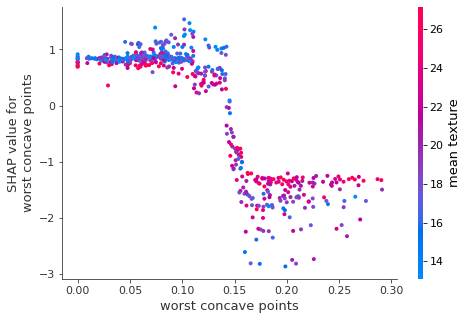

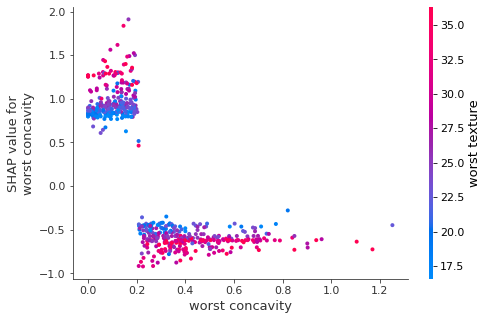

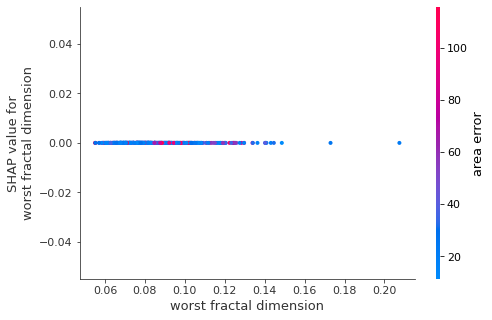

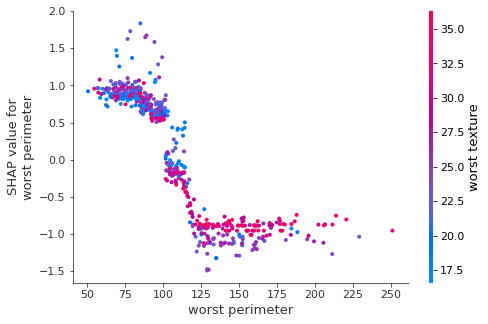

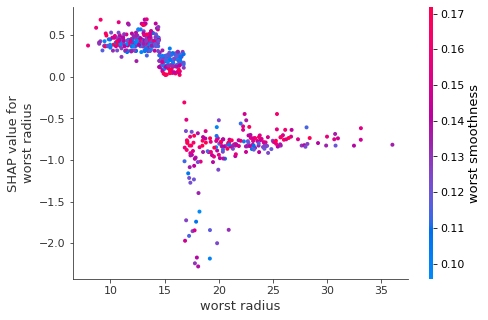

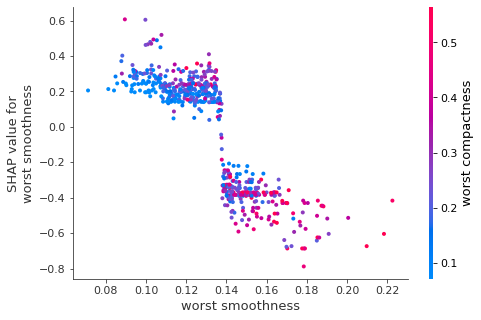

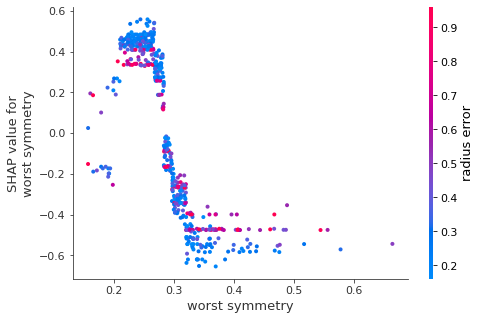

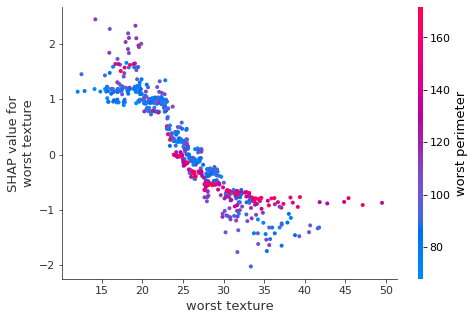

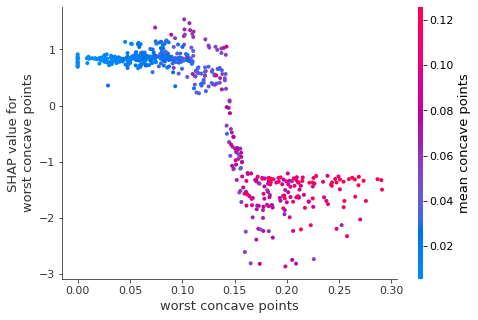

In [51]:
# Generate multiple dependence plots
for name in X_train.columns:
     shap.dependence_plot(name, shap_values, X)
shap.dependence_plot("worst concave points", shap_values, X, interaction_index="mean concave points")

### LIME

In [56]:

# Utilizing our same xgb_mod model object created above
# Import pacakages
import lime
import lime.lime_tabular
import xgboost

############## create explainer ###########
# we use the dataframes splits created above for SHAP
explainer = lime.lime_tabular.LimeTabularExplainer(X_test.to_numpy(), feature_names=X_test.columns, class_names=['0','1'], verbose=True)

############## visualizations #############
X_np = X.to_numpy()
exp = explainer.explain_instance(X_np[79], xgb_mod.predict_proba, num_features=20)
exp.show_in_notebook(show_table=True)

Intercept 0.3666282794780701
Prediction_local [1.36822508]
Right: 0.9997322


### Referrence

In [ ]:
# https://towardsdatascience.com/explainable-ai-xai-a-guide-to-7-packages-in-python-to-explain-your-models-932967f0634b
# https://medium.com/swlh/push-the-limits-of-explainability-an-ultimate-guide-to-shap-library-a110af566a02